# Fraud Detection based on Synthetic Financial Datasets - PySpark Logistic Regression and Multilayer Perceptron

##### By: Ling Jiang, Xinyue Jin, Ming Ki Toby Cheng

## 0) Startup

### 0.a) Import packages

In [56]:
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle


%matplotlib inline


### 0.b) Start Spark session


In [57]:
## initialize Spark

# NOTE: for this assignment, we will enforce using 2 CPU cores. 

import pyspark
import pyspark.sql.functions as f
from pyspark.sql import SparkSession, Row

conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),  # Specify the core number
                                   ('spark.app.name', 'Clustering')])      # Specify the app name
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)

2.4.3 2.4.3


### 0.c) Set random seed

In [58]:
rand_seed = 1234

## 1) Load and prepare data

### 1.a) Load Data

Read data from csv into DataFrames, and load data dictionary from the pickle file. 

In [59]:
data = spark.read.load("file:///home/jovyan/git/big-data-2-project/PS_20174392719_1491204439457_log.csv", format="csv", inferSchema="true", header="true") # YOUR CODE HERE


In [60]:
print(data.count())

6362620


In [61]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [62]:
data = data.withColumn("OrigDiff", data.newbalanceOrig - data.oldbalanceOrg)
data = data.withColumn("DestDiff", data.newbalanceDest - data.oldbalanceDest)

In [63]:
data = data.withColumn(
    'AmountEqOrig',\
    f.when(f.col("amount") == f.col("oldbalanceOrg"), 1)\
    .otherwise(0))

In [64]:
data = data.withColumn(
    'CusToCus',\
    f.when(f.col("nameOrig").contains('C') & f.col("nameDest").contains('C'), 1)\
    .otherwise(0))


In [65]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|           OrigDiff|DestDiff|AmountEqOrig|CusToCus|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|     0.0|           0|       0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|-1864.2799999999988|     0.0|           0|       0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.

In [66]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
data_index = indexer.fit(data).transform(data)

data_index.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+---------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|           OrigDiff|DestDiff|AmountEqOrig|CusToCus|typeIndex|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+---------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|     0.0|           0|       0|      1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|-1864.2799999999988|     0.0|           0|       0|      1.0|
|   1|TRANSFER|   181.0|C1305486145|    

In [67]:
from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=["typeIndex"],
                                 outputCols=["typeVec"])
model = encoder.fit(data_index)
data_encoded = model.transform(data_index)
data_encoded.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+---------+-------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|           OrigDiff|DestDiff|AmountEqOrig|CusToCus|typeIndex|      typeVec|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+--------+------------+--------+---------+-------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|     0.0|           0|       0|      1.0|(4,[1],[1.0])|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|-1864.2799999999988|     0.0|           0|    

In [68]:
data_encoded.show(10)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+-------------------+------------+--------+---------+-------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|           OrigDiff|           DestDiff|AmountEqOrig|CusToCus|typeIndex|      typeVec|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+-------------------+------------+--------+---------+-------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|                0.0|           0|       0|      1.0|(4,[1],[1.0])|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|-1

In [69]:
data_encoded.groupBy('typeIndex').count().show()
data_encoded.groupBy('type').count().show()

+---------+-------+
|typeIndex|  count|
+---------+-------+
|      0.0|2237500|
|      1.0|2151495|
|      4.0|  41432|
|      3.0| 532909|
|      2.0|1399284|
+---------+-------+

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



In [70]:
feature_cols = ['typeVec', 'amount', 'OrigDiff', 'DestDiff','isFraud', 'AmountEqOrig', 'CusToCus']
feature_selection_df = data_encoded.select(feature_cols)
cleaned_df = feature_selection_df.dropna()# YOUR CODE HERE
cleaned_df.show(5)

+-------------+--------+-------------------+--------+-------+------------+--------+
|      typeVec|  amount|           OrigDiff|DestDiff|isFraud|AmountEqOrig|CusToCus|
+-------------+--------+-------------------+--------+-------+------------+--------+
|(4,[1],[1.0])| 9839.64| -9839.640000000014|     0.0|      0|           0|       0|
|(4,[1],[1.0])| 1864.28|-1864.2799999999988|     0.0|      0|           0|       0|
|(4,[3],[1.0])|   181.0|             -181.0|     0.0|      1|           1|       1|
|(4,[0],[1.0])|   181.0|             -181.0|-21182.0|      1|           1|       1|
|(4,[1],[1.0])|11668.14|          -11668.14|     0.0|      0|           0|       0|
+-------------+--------+-------------------+--------+-------+------------+--------+
only showing top 5 rows



In [71]:
orignumRows = feature_selection_df.count()
numRows = cleaned_df.count()
print(orignumRows, numRows)

6362620 6362620


In [72]:
numPositives = cleaned_df.select(f.sum('isFraud')).collect()[0][0]
numPositives

8213

In [73]:
numNegatives = numRows - numPositives
numNegatives

6354407

In [74]:
cleaned_df.groupby('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [75]:
data.groupby('type').count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



In [76]:
data.describe('amount').show()

+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|           6362620|
|   mean|179861.90354913412|
| stddev| 603858.2314629498|
|    min|               0.0|
|    max|     9.244551664E7|
+-------+------------------+



In [77]:
data.describe('step').show()

+-------+------------------+
|summary|              step|
+-------+------------------+
|  count|           6362620|
|   mean|243.39724563151657|
| stddev|142.33197104912588|
|    min|                 1|
|    max|               743|
+-------+------------------+



In [78]:
data.limit(10).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,OrigDiff,DestDiff,AmountEqOrig,CusToCus
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,-9839.64,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,-1864.28,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,-181.00,0.00,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,-181.00,-21182.00,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,-11668.14,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,-7817.71,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,-7107.77,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,-7861.64,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,-2671.00,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,-5337.77,-1549.21,0,1


(0, 6500000)

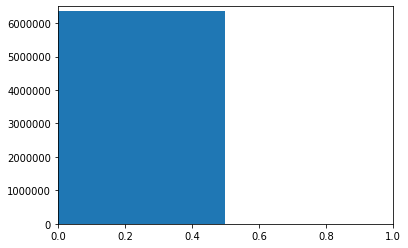

In [79]:
fig = plt.figure()
s = fig.add_subplot(111)
s.bar([0, 1], [numNegatives, numPositives], width=1)
s.set_xlim(0, 1)
s.set_ylim(0, 6500000)

## 2) Data Preprocessing

### 2.b) Assemble a feature vector column 

Assemble a Vector column. Most Spark ML classes only work with Vector objects. 


In [80]:
from pyspark.ml.feature import VectorAssembler

# Create a vector column composed of all the features
feature_only = ['typeVec', 'amount', 'OrigDiff', 'DestDiff', 'AmountEqOrig', 'CusToCus']

assembler = VectorAssembler(inputCols = feature_only, outputCol = "features_unscaled") # YOUR CODE HERE

features_df = assembler.transform(cleaned_df)# YOUR CODE HERE
features_df.show(5)


+-------------+--------+-------------------+--------+-------+------------+--------+--------------------+
|      typeVec|  amount|           OrigDiff|DestDiff|isFraud|AmountEqOrig|CusToCus|   features_unscaled|
+-------------+--------+-------------------+--------+-------+------------+--------+--------------------+
|(4,[1],[1.0])| 9839.64| -9839.640000000014|     0.0|      0|           0|       0|(9,[1,4,5],[1.0,9...|
|(4,[1],[1.0])| 1864.28|-1864.2799999999988|     0.0|      0|           0|       0|(9,[1,4,5],[1.0,1...|
|(4,[3],[1.0])|   181.0|             -181.0|     0.0|      1|           1|       1|[0.0,0.0,0.0,1.0,...|
|(4,[0],[1.0])|   181.0|             -181.0|-21182.0|      1|           1|       1|[1.0,0.0,0.0,0.0,...|
|(4,[1],[1.0])|11668.14|          -11668.14|     0.0|      0|           0|       0|(9,[1,4,5],[1.0,1...|
+-------------+--------+-------------------+--------+-------+------------+--------+--------------------+
only showing top 5 rows



### 2.c) Randomly split the DataFrame into train and test datasets

Perform a random train-test split of the dataframe using the random seed you set earlier


In [81]:
train_df, test_df = features_df.randomSplit((0.8,0.2),seed=rand_seed)# YOUR CODE HERE
train_df.show(5)
test_df.show(5)

+---------+------+-------------------+------------------+-------+------------+--------+--------------------+
|  typeVec|amount|           OrigDiff|          DestDiff|isFraud|AmountEqOrig|CusToCus|   features_unscaled|
+---------+------+-------------------+------------------+-------+------------+--------+--------------------+
|(4,[],[])|  3.81|-3.8100000000000023| 577718.0899999999|      0|           0|       1|(9,[4,5,6,8],[3.8...|
|(4,[],[])|  3.83|-3.8299999999580905|        1547379.38|      0|           0|       1|(9,[4,5,6,8],[3.8...|
|(4,[],[])|  4.62| -4.619999999995343|-278555.0499999998|      0|           0|       1|(9,[4,5,6,8],[4.6...|
|(4,[],[])|  5.39| -5.389999999999418|476333.83999999985|      0|           0|       1|(9,[4,5,6,8],[5.3...|
|(4,[],[])|  6.57| -6.569999999999709| 6.569999999977881|      0|           0|       1|(9,[4,5,6,8],[6.5...|
+---------+------+-------------------+------------------+-------+------------+--------+--------------------+
only showing top 5 

### 2.d) Normalize values in the dataframes by fitting a StandardScaler on them

Fit a StandardScaler on our train set, and use it to transform both the train and test sets to have zero mean and unit variance
- **fit**(train_set) -- calculates means and standard devations of train set
- **transform**(train or test set) -- standardizes each column by subtracting the mean and dividing by the standard deviation (corresponding to the data on which it was fit)<br>

This means that each feature of our data will be scaled with respect to the means and standard deviations of the training set only (which is important when we want to see how well the model generalizes to new data).

Fit a StandardScaler on the training data, and normalize both train and test datasets


In [82]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol = "features_unscaled", 
                        outputCol = "features",
                        withStd = True, withMean = True)# YOUR CODE HERE
scalerModel = scaler.fit(train_df)

train_df = scalerModel.transform(train_df)# YOUR CODE HERE
test_df = scalerModel.transform(test_df) # YOUR CODE HERE
train_df.show(5)
test_df.show(5)

+---------+------+-------------------+------------------+-------+------------+--------+--------------------+--------------------+
|  typeVec|amount|           OrigDiff|          DestDiff|isFraud|AmountEqOrig|CusToCus|   features_unscaled|            features|
+---------+------+-------------------+------------------+-------+------------+--------+--------------------+--------------------+
|(4,[],[])|  3.81|-3.8100000000000023| 577718.0899999999|      0|           0|       1|(9,[4,5,6,8],[3.8...|[-0.7363392917938...|
|(4,[],[])|  3.83|-3.8299999999580905|        1547379.38|      0|           0|       1|(9,[4,5,6,8],[3.8...|[-0.7363392917938...|
|(4,[],[])|  4.62| -4.619999999995343|-278555.0499999998|      0|           0|       1|(9,[4,5,6,8],[4.6...|[-0.7363392917938...|
|(4,[],[])|  5.39| -5.389999999999418|476333.83999999985|      0|           0|       1|(9,[4,5,6,8],[5.3...|[-0.7363392917938...|
|(4,[],[])|  6.57| -6.569999999999709| 6.569999999977881|      0|           0|       1|(9,

In [83]:
BalancingRatio= numNegatives/numRows
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.9987091795518198


In [84]:
train_df=train_df.withColumn("classWeights", f.when(train_df.isFraud == 1,BalancingRatio).otherwise(1-BalancingRatio))
train_df.select("classWeights").show(5)

+--------------------+
|        classWeights|
+--------------------+
|0.001290820448180...|
|0.001290820448180...|
|0.001290820448180...|
|0.001290820448180...|
|0.001290820448180...|
+--------------------+
only showing top 5 rows



## 3) Classification using Logistic Regression

In [30]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="isFraud", featuresCol="features",weightCol="classWeights",maxIter=10)
model=lr.fit(train_df)
predict_train=model.transform(train_df)
predict_test=model.transform(test_df)
predict_test.select("isFraud","prediction").show(10)

+-------+----------+
|isFraud|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
+-------+----------+
only showing top 10 rows



In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="isFraud")

predict_test.select("isFraud","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+-------+--------------------+----------+--------------------+
|isFraud|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[6.49468247312774...|       0.0|[0.99849082598400...|
|      0|[6.31819583405064...|       0.0|[0.99820005182125...|
|      0|[6.318195188257,-...|       0.0|[0.99820005066095...|
|      0|[6.32133485840001...|       0.0|[0.99820568292167...|
|      0|[6.31818581519121...|       0.0|[0.99820003382020...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.999015613093102
The area under ROC for test set is 0.9993384755465694


In [32]:
#evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="isFraud")
evaluator=BinaryClassificationEvaluator(labelCol="isFraud",metricName='areaUnderROC')

predict_test.select("isFraud","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+-------+--------------------+----------+--------------------+
|isFraud|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[6.49468247312774...|       0.0|[0.99849082598400...|
|      0|[6.31819583405064...|       0.0|[0.99820005182125...|
|      0|[6.318195188257,-...|       0.0|[0.99820005066095...|
|      0|[6.32133485840001...|       0.0|[0.99820568292167...|
|      0|[6.31818581519121...|       0.0|[0.99820003382020...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9990156130924803
The area under ROC for test set is 0.9993384755471701


In [33]:
train_predyes = predict_train.agg(f.sum("prediction")).collect()[0][0]
train_predyes

6569.0

In [34]:
test_predyes = predict_test.agg(f.sum("prediction")).collect()[0][0]
test_predyes

1637.0

In [35]:
train_count = predict_train.select("prediction").count()
train_count

5091286

In [36]:
test_count = predict_test.select("prediction").count()
test_count

1271334

In [37]:
#train predicting yes precentage
train_predyes/train_count

0.0012902437615957933

In [38]:
#test predicting yes precentage
test_predyes/test_count

0.0012876238659549732

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

y_true_train = predict_train.select(['isFraud']).collect()
y_pred_train = predict_train.select(['prediction']).collect()

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5084714
           1       1.00      1.00      1.00      6572

    accuracy                           1.00   5091286
   macro avg       1.00      1.00      1.00   5091286
weighted avg       1.00      1.00      1.00   5091286



In [40]:
tn, fp, fn, tp = confusion_matrix(y_true_train, y_pred_train).ravel()
(tn, fp, fn, tp)

(5084692, 22, 25, 6547)

In [41]:
y_true = predict_test.select(['isFraud']).collect()
y_pred = predict_test.select(['prediction']).collect()

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(1269689, 4, 8, 1633)

In [42]:
from sklearn import metrics
f1 = metrics.fbeta_score(y_true, y_pred, beta = 1)
f1

0.9963392312385602

In [43]:
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [0.2865887693794584,-0.1548749000330418,-0.88847349828836,0.2248359700842378,0.41213679206349657,-0.05158101172026544,-0.47259133461328795,0.405480991462613,0.15487490003303997]
Intercept: -6.675238107359787


In [44]:
log_odds_ratios = np.exp(model.coefficients)
log_odds_ratios

array([1.33187639, 0.85652232, 0.4112831 , 1.25211731, 1.51004098,
       0.94972671, 0.62338477, 1.50002383, 1.1675119 ])

In [45]:
temp = predict_test.select('typeVec','amount','AmountEqOrig','CusToCus','probability','prediction','isFraud')

In [46]:
temp.filter( (temp.prediction==0) & (temp.isFraud==1 )).show(10)

+-------------+---------+------------+--------+--------------------+----------+-------+
|      typeVec|   amount|AmountEqOrig|CusToCus|         probability|prediction|isFraud|
+-------------+---------+------------+--------+--------------------+----------+-------+
|(4,[0],[1.0])| 95428.32|           0|       1|[0.99669327564200...|       0.0|      1|
|(4,[0],[1.0])|234377.29|           0|       1|[0.99664748085947...|       0.0|      1|
|(4,[0],[1.0])|314251.58|           0|       1|[0.99652978712538...|       0.0|      1|
|(4,[0],[1.0])|407005.78|           0|       1|[0.99658970459613...|       0.0|      1|
|(4,[0],[1.0])| 508782.2|           0|       1|[0.99655517763544...|       0.0|      1|
|(4,[0],[1.0])|577418.98|           0|       1|[0.99653169661464...|       0.0|      1|
|(4,[3],[1.0])| 994453.2|           0|       1|[0.99146247423639...|       0.0|      1|
|(4,[3],[1.0])|399045.08|           0|       1|[0.99470467671888...|       0.0|      1|
+-------------+---------+-------

In [47]:
temp.filter((temp.isFraud == 1) & (temp.AmountEqOrig==0)).count()

36

In [48]:
temp.filter((temp.isFraud == 1) & (temp.AmountEqOrig==0)).show(36)

+-------------+---------+------------+--------+--------------------+----------+-------+
|      typeVec|   amount|AmountEqOrig|CusToCus|         probability|prediction|isFraud|
+-------------+---------+------------+--------+--------------------+----------+-------+
|(4,[0],[1.0])| 95428.32|           0|       1|[0.99669327564200...|       0.0|      1|
|(4,[0],[1.0])|234377.29|           0|       1|[0.99664748085947...|       0.0|      1|
|(4,[0],[1.0])|314251.58|           0|       1|[0.99652978712538...|       0.0|      1|
|(4,[0],[1.0])|407005.78|           0|       1|[0.99658970459613...|       0.0|      1|
|(4,[0],[1.0])| 508782.2|           0|       1|[0.99655517763544...|       0.0|      1|
|(4,[0],[1.0])|577418.98|           0|       1|[0.99653169661464...|       0.0|      1|
|(4,[3],[1.0])| 994453.2|           0|       1|[0.99146247423639...|       0.0|      1|
|(4,[3],[1.0])|    1.0E7|           0|       1|[0.00806411573733...|       1.0|      1|
|(4,[3],[1.0])|    1.0E7|       

## 4) Classification using Multilayer perceptron classifier (1 layers of 1 nodes)

In [49]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# specify layers for the neural network:
# input layer of size 9 (features), 1 intermediate of size 1
# and output of size 2 (classes)
layers1 = [9, 1, 2]

# create the trainer and set its parameters
trainer1 = MultilayerPerceptronClassifier(maxIter=100, layers=layers1, blockSize=128, labelCol='isFraud', seed=rand_seed)

# train the model
model_nn1 = trainer1.fit(train_df)

# compute accuracy on the test set
predict_train_nn1 = model_nn1.transform(train_df)
predict_test_nn1 = model_nn1.transform(test_df)

In [50]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="isFraud")

predict_test_nn1.select("isFraud","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_nn1)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_nn1)))

+-------+--------------------+----------+--------------------+
|isFraud|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[7.17792741858005...|       0.0|[0.99999833741463...|
|      0|[7.17805715762398...|       0.0|[0.99999833785781...|
|      0|[7.17805714648954...|       0.0|[0.99999833785777...|
|      0|[7.17805475917749...|       0.0|[0.99999833784962...|
|      0|[7.17805698324754...|       0.0|[0.99999833785721...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9987604767661898
The area under ROC for test set is 0.9989250147234263


In [51]:
y_true_train_nn1 = predict_train_nn1.select(['isFraud']).collect()
y_pred_train_nn1 = predict_train_nn1.select(['prediction']).collect()

tn, fp, fn, tp = confusion_matrix(y_true_train_nn1, y_pred_train_nn1).ravel()
(tn, fp, fn, tp)

(5084714, 0, 29, 6543)

In [52]:
y_true_test_nn1 = predict_test_nn1.select(['isFraud']).collect()
y_pred_test_nn1 = predict_test_nn1.select(['prediction']).collect()

tn, fp, fn, tp = confusion_matrix(y_true_test_nn1, y_pred_test_nn1).ravel()
(tn, fp, fn, tp)

(1269693, 0, 8, 1633)

In [53]:
f1 = metrics.fbeta_score(y_true_test_nn1, y_pred_test_nn1, beta = 1)
f1

0.9975565058032988

### 5) Stop Spark

In [54]:
spark.stop()